#  Projet de Deep Learning  
## Classification Automatique des Tumeurs Cérébrales à partir d’Images IRM


##  Objectif du Projet

L’objectif de ce projet est de concevoir et d’entraîner un modèle de **Deep Learning** capable de classifier automatiquement des images IRM du cerveau en quatre catégories :
- Glioma  
- Meningioma  
- Pituitary tumor  
- No tumor  

Ce système vise à assister le diagnostic médical en utilisant des techniques avancées de **Vision par Ordinateur**.


In [81]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# =========================

In [79]:
train_dir = '/content/brain_tumor_data/Training'
test_dir  = '/content/brain_tumor_data/Testing'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_to_index = {cls:i for i, cls in enumerate(classes)}

IMAGE_SIZE = 224

##  Description du Dataset

Le dataset est divisé en deux parties principales :

- **Training** : utilisé pour l’apprentissage du modèle  
- **Testing** : utilisé pour l’évaluation des performances finales  

Chaque dossier contient quatre sous-dossiers correspondant aux classes de tumeurs.  
Les images sont des IRM cérébrales au format RGB.


## 🔢 Encodage des Classes

Les labels textuels sont transformés en valeurs numériques afin d’être exploitables par le modèle :

- glioma → 0  
- meningioma → 1  
- notumor → 2  
- pituitary → 3  

Cet encodage permet l’utilisation de la fonction de perte `sparse_categorical_crossentropy`.


In [82]:
train_paths = []
train_labels = []

for label in classes:
    folder = os.path.join(train_dir, label)
    for img in os.listdir(folder):
        train_paths.append(os.path.join(folder, img))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in classes:
    folder = os.path.join(test_dir, label)
    for img in os.listdir(folder):
        test_paths.append(os.path.join(folder, img))
        test_labels.append(label)

print("Training samples:", len(train_paths))
print("Test samples:", len(test_paths))

Training samples: 5712
Test samples: 1311


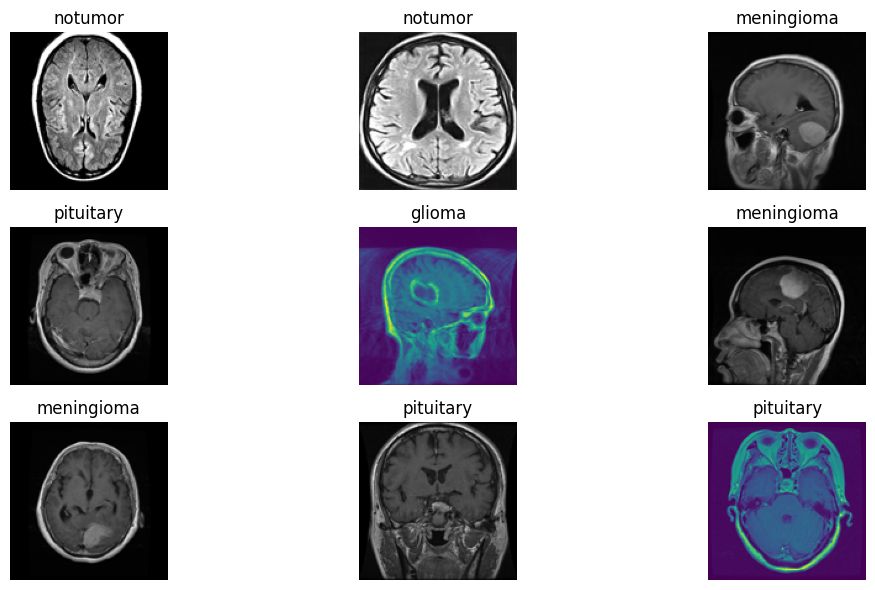

In [83]:
# =========================
# VISUALIZATION
# =========================

sample_idx = random.sample(range(len(train_paths)), 9)

plt.figure(figsize=(12,6))

for i, idx in enumerate(sample_idx):
    img = Image.open(train_paths[idx]).resize((128,128))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(train_labels[idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

## 🔄 Augmentation des Données

Pour améliorer la généralisation du modèle et réduire l’overfitting, des techniques d’augmentation sont appliquées sur les images d’entraînement :

- Variation aléatoire de la luminosité  
- Variation aléatoire du contraste  

Ces transformations augmentent artificiellement la diversité du dataset.


In [84]:
# =========================
# AUGMENTATION
# =========================

def augment_image(image):
    image = Image.fromarray(image.astype('uint8'))

    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))

    image = np.array(image) / 255.0
    return image

## 🖼️ Prétraitement des Images

Toutes les images sont :
- Redimensionnées à **224 × 224 pixels**
- Normalisées entre **0 et 1**
- Converties en tableaux NumPy  

Ce prétraitement assure une compatibilité avec l’architecture VGG16.


In [85]:
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_to_array(img)
        img = augment_image(img)
        images.append(img)
    return np.array(images)

def open_images_no_aug(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)


In [86]:
# =========================
# LABEL ENCODING
# =========================

def encode_label(labels):
    return np.array([class_to_index[l] for l in labels])


##  Générateur de Données

Un générateur personnalisé est utilisé pour :
- Charger les images par batch
- Appliquer l’augmentation en temps réel
- Mélanger les données à chaque époque  

Cette approche permet un entraînement plus efficace et une meilleure gestion de la mémoire.


In [87]:
# =========================
# DATA GENERATOR
# =========================

def datagen(paths, labels, batch_size=32):
    while True:
        paths, labels = shuffle(paths, labels)

        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            X = open_images(batch_paths)
            y = encode_label(batch_labels)

            yield X, y

##  Architecture du Modèle

Le modèle est basé sur le **Transfer Learning** avec **VGG16** pré-entraîné sur ImageNet :

- Suppression des couches fully-connected originales
- Gel partiel des couches convolutionnelles
- Ajout de couches personnalisées :
  - Global Average Pooling
  - Dense (256 neurones, ReLU)
  - Batch Normalization
  - Dropout
  - Couche de sortie Softmax


In [88]:
# =========================
# MODEL — VGG16 TRANSFER
# =========================

base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 7,212,292 (27.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

##  Entraînement du Modèle

Paramètres d’entraînement :
- Optimiseur : **Adam**
- Learning rate : **1e-4**
- Batch size : **32**
- Nombre d’époques : **25**

Des callbacks sont utilisés :
- **EarlyStopping** pour éviter l’overfitting
- **ReduceLROnPlateau** pour ajuster automatiquement le learning rate


In [89]:
# =========================
# TRAINING
# =========================

batch_size = 32
epochs = 25

train_steps = len(train_paths) // batch_size
val_steps   = len(test_paths) // batch_size

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

history = model.fit(
    datagen(train_paths, train_labels, batch_size),
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=datagen(test_paths, test_labels, batch_size),
    validation_steps=val_steps,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.5791 - loss: 1.1666 - val_accuracy: 0.7977 - val_loss: 0.5912 - learning_rate: 1.0000e-04
Epoch 2/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 87s 470ms/step - accuracy: 0.8749 - loss: 0.3566 - val_accuracy: 0.8641 - val_loss: 0.3489 - learning_rate: 1.0000e-04
Epoch 3/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 51s 286ms/step - accuracy: 0.9144 - loss: 0.2313 - val_accuracy: 0.8641 - val_loss: 0.4760 - learning_rate: 1.0000e-04
Epoch 4/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.9380 - loss: 0.1621 - val_accuracy: 0.9547 - val_loss: 0.1293 - learning_rate: 1.0000e-04
Epoch 5/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.9560 - loss: 0.1169 - val_accuracy: 0.9664 - val_loss: 0.1099 - learning_rate: 1.0000e-04
Epoch 6/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.9705 - loss: 0.0855 - val_accuracy: 0.9586 - val_loss: 0.1183 - learning_rate: 1.0000e-04
Epoch 7/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 46

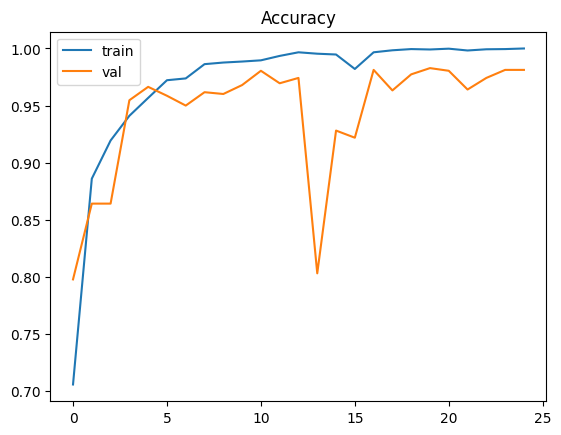

In [90]:
# =========================
# CURVES
# =========================

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.title("Accuracy")
plt.show()

##  Évaluation des Performances

Le modèle est évalué sur le jeu de test à l’aide de plusieurs métriques :
- Accuracy
- Precision
- Recall
- F1-score
- AUC
- Balanced Accuracy
- Matrice de confusion  

Ces métriques permettent une analyse complète des performances pour chaque classe.


In [123]:
# =========================
# EVALUATION
# =========================

test_images = open_images_no_aug(test_paths)
test_labels_encoded = encode_label(test_labels)

preds = model.predict(test_images)

print(classification_report(
    test_labels_encoded,
    np.argmax(preds, axis=1),
    target_names=classes
))



41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       300
  meningioma       0.94      0.99      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



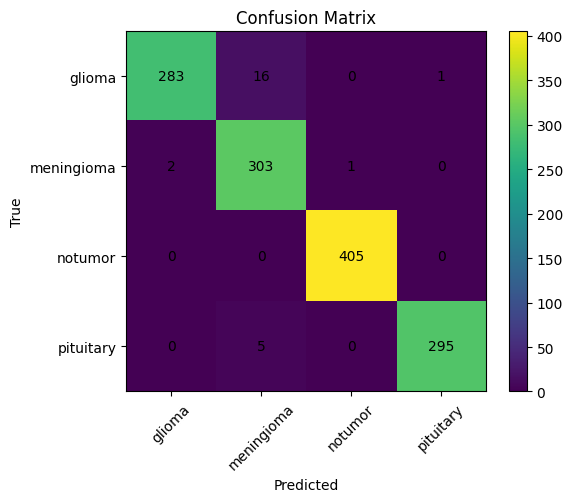

In [103]:
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.xlabel("Predicted")
plt.ylabel("True")

# afficher valeurs dans les cases
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i,j],
                 ha="center",
                 va="center")

plt.tight_layout()
plt.show()


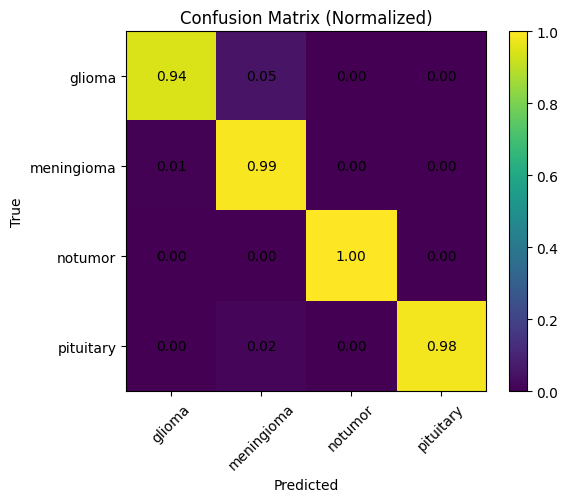

In [104]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
plt.imshow(cm_norm)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()

plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i,
                 f"{cm_norm[i,j]:.2f}",
                 ha="center",
                 va="center")

plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [105]:
preds = model.predict(test_images)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


In [109]:
# prédictions probabilités
preds = model.predict(test_images)

# conversion en classes
y_pred = np.argmax(preds, axis=1)

# labels vrais
y_true = test_labels_encoded   # ou encode_label(test_labels)

print("Shapes:", y_true.shape, y_pred.shape)


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step
Shapes: (1311,) (1311,)


In [110]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", round(test_acc,4))


Test Accuracy: 0.9809


In [111]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision macro:", precision_score(y_true, y_pred, average='macro'))
print("Precision weighted:", precision_score(y_true, y_pred, average='weighted'))
print()

print("Recall macro:", recall_score(y_true, y_pred, average='macro'))
print("Recall weighted:", recall_score(y_true, y_pred, average='weighted'))
print()

print("F1 macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_true, y_pred, average='weighted'))


Precision macro: 0.9805815521899913
Precision weighted: 0.9817317719675406

Recall macro: 0.9792156862745098
Recall weighted: 0.9809305873379099

F1 macro: 0.9795314924273704
F1 weighted: 0.9809914185308092


In [112]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=classes
))


              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       300
  meningioma       0.94      0.99      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [113]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[283  16   0   1]
 [  2 303   1   0]
 [  0   0 405   0]
 [  0   5   0 295]]


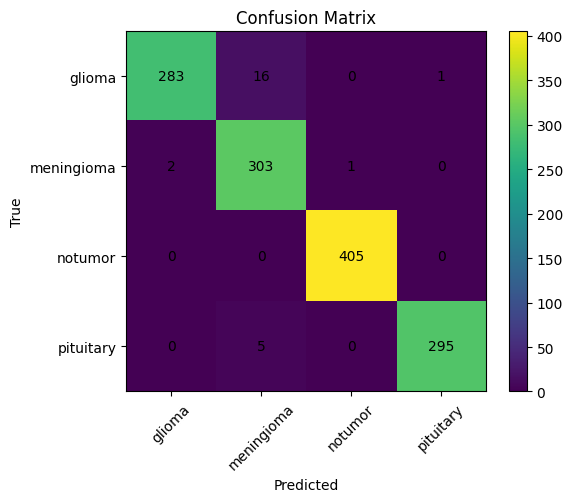

In [114]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


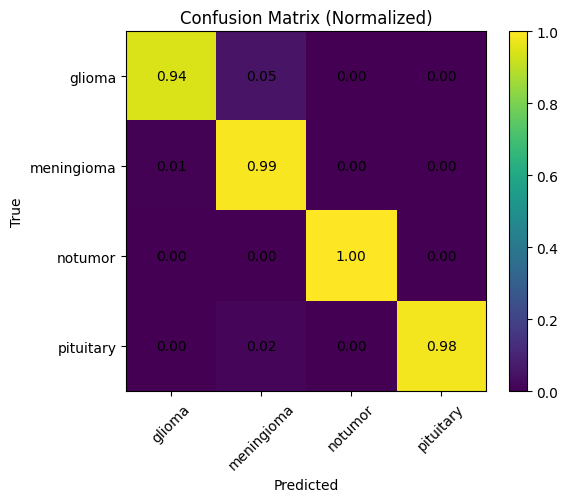

In [115]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
plt.imshow(cm_norm)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()

plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}",
                 ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


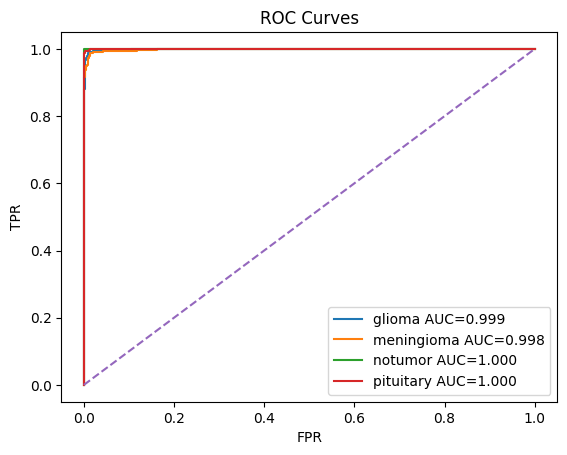

Mean AUC: 0.9992370678414165


In [116]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i],
             label=f"{classes[i]} AUC={roc_auc[i]:.3f}")

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print("Mean AUC:", np.mean(list(roc_auc.values())))


In [117]:
from sklearn.metrics import balanced_accuracy_score

print("Balanced Accuracy:",
      balanced_accuracy_score(y_true, y_pred))


Balanced Accuracy: 0.9792156862745098


In [118]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics = {}

# Accuracy
metrics["accuracy"] = accuracy_score(y_true, y_pred)

# ===== PRECISION =====
metrics["precision_micro"] = precision_score(y_true, y_pred, average="micro")
metrics["precision_macro"] = precision_score(y_true, y_pred, average="macro")   # PU
metrics["precision_weighted"] = precision_score(y_true, y_pred, average="weighted")  # PA

# ===== RECALL =====
metrics["recall_micro"] = recall_score(y_true, y_pred, average="micro")
metrics["recall_macro"] = recall_score(y_true, y_pred, average="macro")
metrics["recall_weighted"] = recall_score(y_true, y_pred, average="weighted")

# ===== F1 =====
metrics["f1_micro"] = f1_score(y_true, y_pred, average="micro")
metrics["f1_macro"] = f1_score(y_true, y_pred, average="macro")
metrics["f1_weighted"] = f1_score(y_true, y_pred, average="weighted")

# ===== PRINT =====
print("\n===== METRICS AVERAGES =====\n")

for k,v in metrics.items():
    print(f"{k:20s} : {v:.4f}")



===== METRICS AVERAGES =====

accuracy             : 0.9809
precision_micro      : 0.9809
precision_macro      : 0.9806
precision_weighted   : 0.9817
recall_micro         : 0.9809
recall_macro         : 0.9792
recall_weighted      : 0.9809
f1_micro             : 0.9809
f1_macro             : 0.9795
f1_weighted          : 0.9810


## Résultats Obtenus

- Accuracy globale : **98.09 %**
- F1-score macro : **97.95 %**
- AUC moyenne : **0.999**
- Excellente détection de la classe *No Tumor*
- Très faibles taux de confusion entre les classes tumorales


## ✅ Conclusion

Ce projet démontre l’efficacité du **Transfer Learning avec VGG16** pour la classification des tumeurs cérébrales à partir d’IRM.

Les résultats obtenus montrent :
- Une forte capacité de généralisation
- Une grande fiabilité pour l’aide au diagnostic médical
- Un modèle robuste et performant adapté aux applications médicales
